# Make your satellite image pop!

![NASA](https://landsat.usgs.gov/sites/default/files/images/Handbook29.jpg)

In [31]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np

import boto3
import rasterio
from rasterio.plot import show, show_hist, reshape_as_raster
from skimage.exposure import equalize_adapthist

In [2]:
plt.rcParams['figure.figsize'] = 20, 20

In [7]:
session = boto3.Session(profile_name='default')

In [92]:
scenes = [
    'LC08_L1TP_205021_20180625_20180704_01_T1',
    'LC08_L1TP_205021_20180727_20180731_01_T1'
]

In [94]:
!gdalinfo data/LC08_L1TP_205021_20180625_20180704_01_T1/LC08_L1TP_205021_20180625_20180704_01_T1_B1.TIF

Driver: GTiff/GeoTIFF
Files: data/LC08_L1TP_205021_20180625_20180704_01_T1/LC08_L1TP_205021_20180625_20180704_01_T1_B1.TIF
       data/LC08_L1TP_205021_20180625_20180704_01_T1/LC08_L1TP_205021_20180625_20180704_01_T1_MTL.txt
Size is 8061, 8151
Coordinate System is:
PROJCS["WGS 84 / UTM zone 30N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]

In [96]:
def get_aws_band(scene, band, profile=False):
    path, row = re.match(r'LC08_L1TP_(\d{3})(\d{3})', scene).groups()
    prefix = 'c1/L8/{}/{}/{}'.format(path, row, scene)
    with rasterio.Env(session=session):
        with rasterio.open(f's3://landsat-pds/{prefix}/{scene}_B{band}.TIF') as src:
            # Retrieves full image at tenth scale, change values height and width are divided
            # by for other scales.
            if profile:
                return src.profile
            return src.read(out_shape=(src.height//10, src.width//10))

In [98]:
stacked_scenes = []
for scene in scenes:
    red = get_aws_band(scene, 4)[0]
    green = get_aws_band(scene, 3)[0]
    blue = get_aws_band(scene, 2)[0]

    stacked_scenes.append(np.stack([red, green, blue]))

In [ ]:
#p = Path('data/')
#scene_dirs = [path for path in p.iterdir() if path.is_dir()]
#scene_dirs

In [ ]:
#scene_root_path = scene_dirs[1]
#scene_id = scene_root_path.parts[-1]
#scene_id

In [ ]:
#def get_band(scene_root_path, band_number):
#    path = scene_root_path.joinpath(f"{scene_id}_B{band_number}.TIF")
#    
#    with rasterio.open(path) as src:
#        return src.read(1)        

In [ ]:
#red = get_band(scene_root_path, 4)
#green = get_band(scene_root_path, 3)
#blue = get_band(scene_root_path, 2)

## Let's plot our downloaded image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


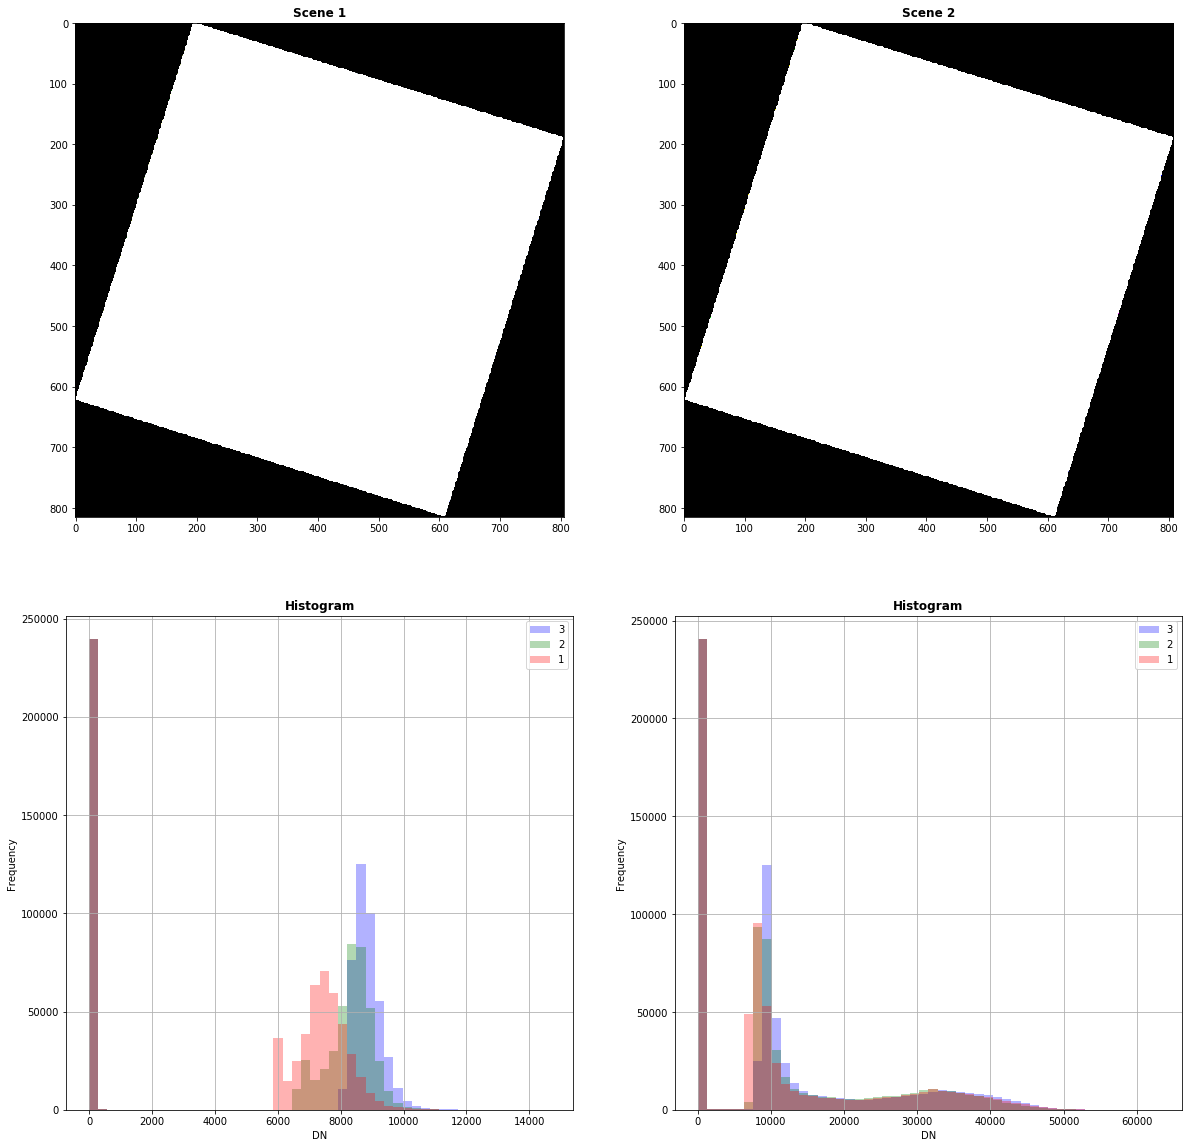

In [81]:
fig, axes = plt.subplots(2,2, figsize=(20,20))

show(stacked_scenes[0], title="Scene 1", ax=axes[0, 0])
show(stacked_scenes[1], title="Scene 2", ax=axes[0, 1])
show_hist(
    stacked_scenes[0], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 0])
show_hist(
    stacked_scenes[1], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 1])

## Too much information, I can't see all that data

In [89]:
def linear_rescale(image, in_range=[0, 14000], out_range=[1, 255]):
    """
    Linear rescaling
    """

    image = np.clip(image, in_range[0], in_range[1]) - in_range[0]
    image = image / float(in_range[1] - in_range[0])

    return (image * (out_range[1] - out_range[0]) + out_range[0]).astype(np.uint8)

In [90]:
linear_rescaled_images = [linear_rescale(stack) for stack in stacked_scenes]

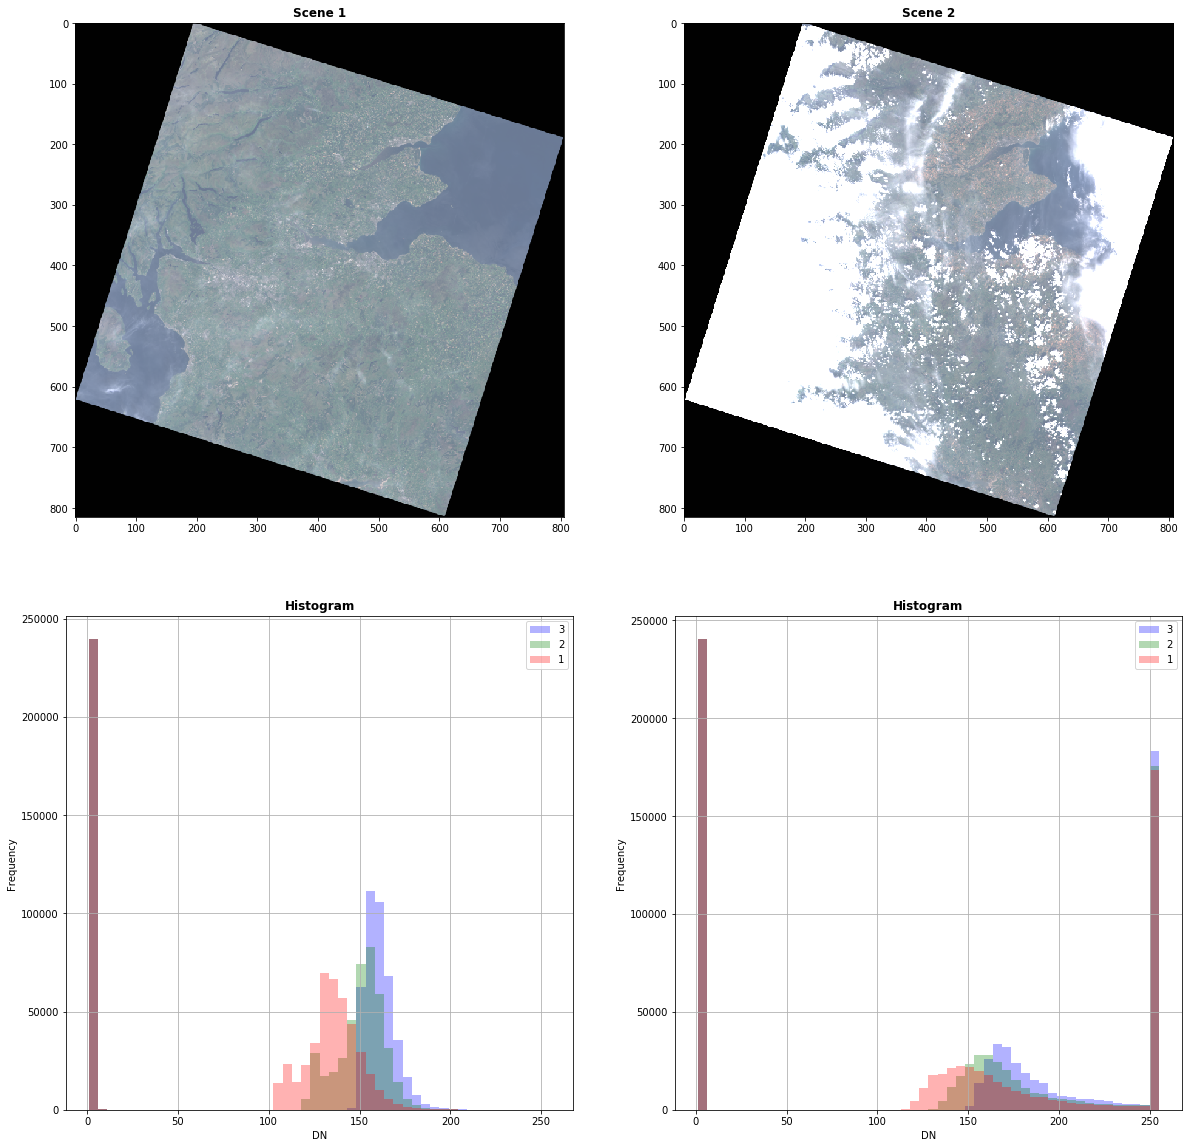

In [91]:
fig, axes = plt.subplots(2,2, figsize=(20,20))

show(linear_rescaled_images[0], title="Scene 1", ax=axes[0, 0])
show(linear_rescaled_images[1], title="Scene 2", ax=axes[0, 1])
show_hist(
    linear_rescaled_images[0], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 0])
show_hist(
    linear_rescaled_images[1], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 1])

## That's not very pretty

In [66]:
def percentile_stretch(image):
    mask = np.all(image != 0, axis=0).astype(np.uint8) * 255
    image_out = np.zeros_like(image).astype(np.uint8)
    for band in range(image.shape[0]):
        input_range = np.percentile(image[band][mask > 0], (2, 98)).tolist()
        image_out[band] = np.where(
                mask, linear_rescale(image[band], in_range=input_range, out_range=[0, 255]), 0
        )
    
    return image_out

In [67]:
percentile_stretched_images = [percentile_stretch(stack) for stack in stacked_scenes]

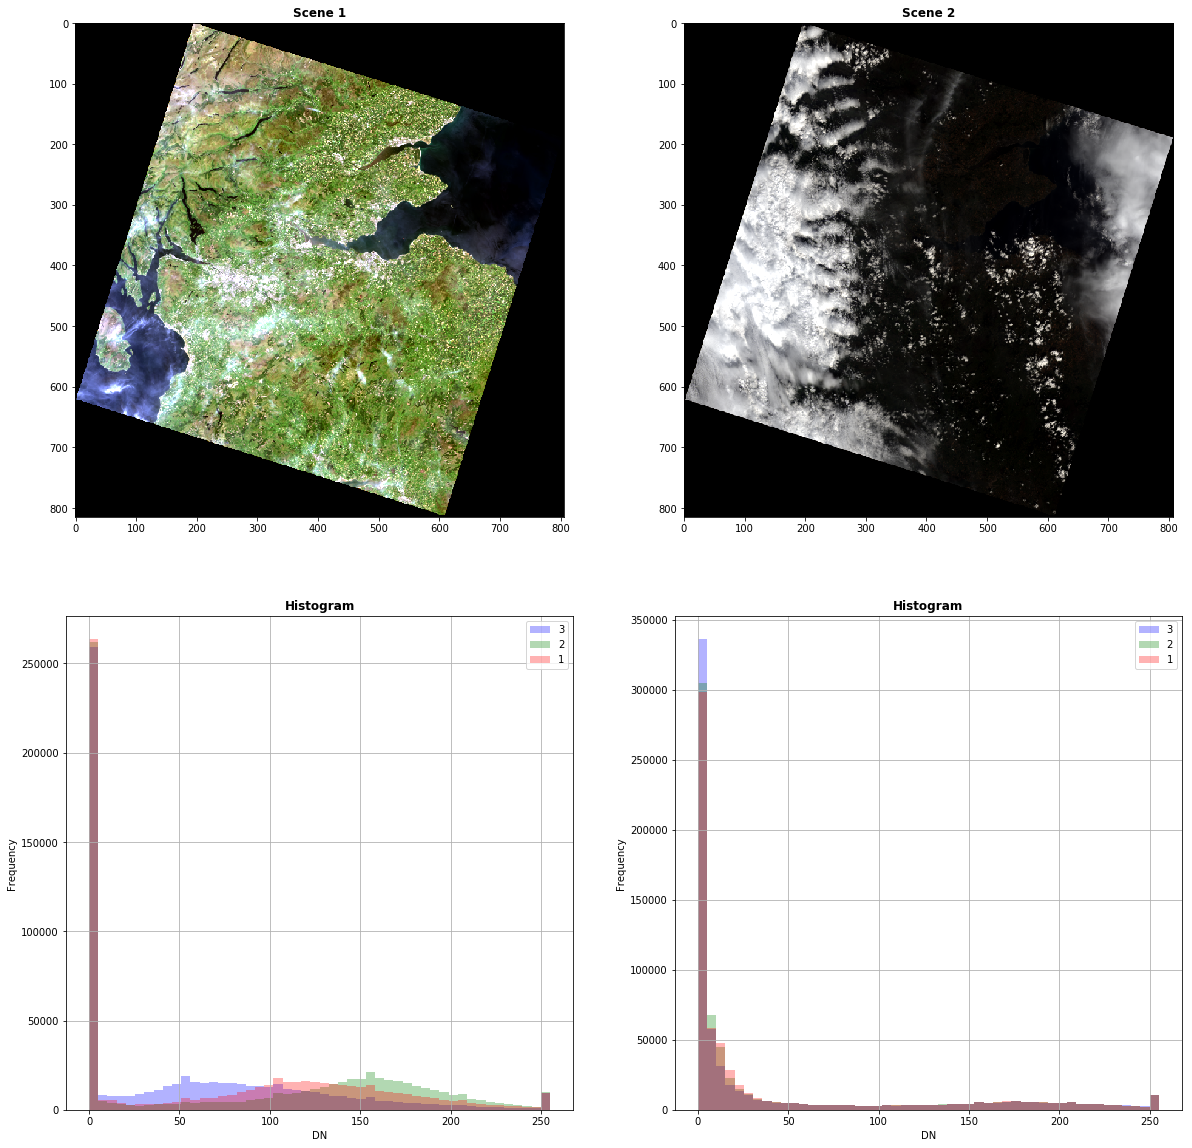

In [83]:
fig, axes = plt.subplots(2,2, figsize=(20,20))

show(percentile_stretched_images[0], title="Scene 1", ax=axes[0, 0])
show(percentile_stretched_images[1], title="Scene 2", ax=axes[0, 1])
show_hist(
    percentile_stretched_images[0], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 0])
show_hist(
    percentile_stretched_images[1], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 1])

## Give me more detail

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/AHE-neighbourhoods.svg/432px-AHE-neighbourhoods.svg.png) ![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Clahe-redist.svg/300px-Clahe-redist.svg.png)

In [69]:
def clahe_equalize(image, kernel_size=2000, clip_limit=0.03):
    image_out = np.zeros_like(image).astype(np.float64)
    for band in range(image.shape[0]):
        image_out[band] = equalize_adapthist(image[band], kernel_size=kernel_size, clip_limit=clip_limit)
            
    return image_out

In [70]:
raster_equalized_images = [clahe_equalize(stack, clip_limit=0.05) for stack in stacked_scenes]

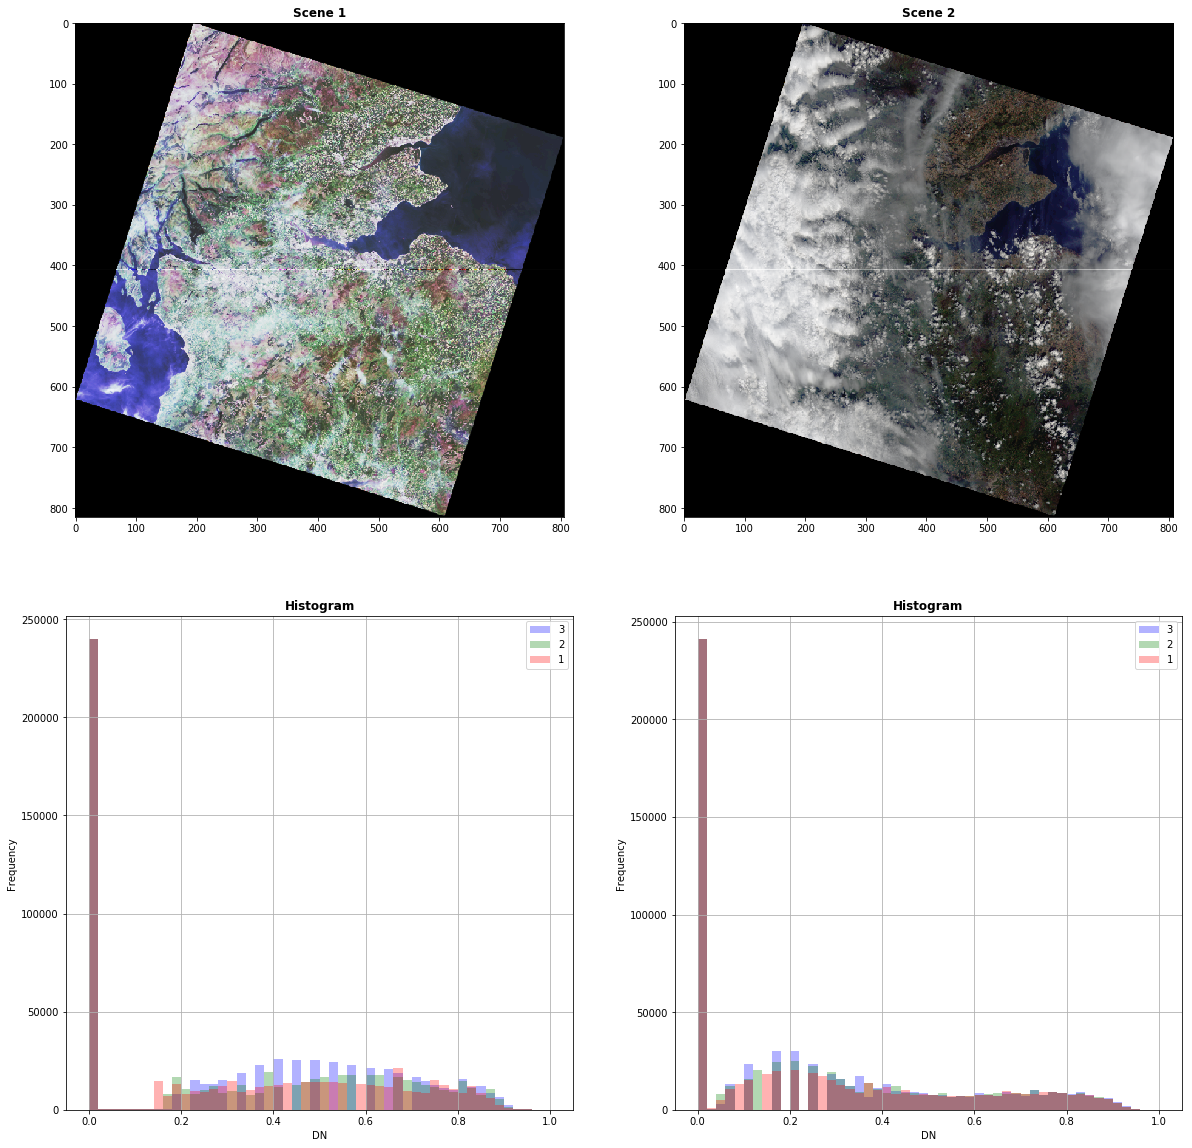

In [84]:
fig, axes = plt.subplots(2,2, figsize=(20,20))

show(raster_equalized_images[0], title="Scene 1", ax=axes[0, 0])
show(raster_equalized_images[1], title="Scene 2", ax=axes[0, 1])
show_hist(
    raster_equalized_images[0], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 0])
show_hist(
    raster_equalized_images[1], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", ax=axes[1, 1])

## It's a bit fake though, right

## Export for display

In [95]:
def write_rendered_rgb(rgb, profile, outname_prefix):
    """
    Write a rendered RGB to GeoTIFF.
    """
    profile.update(dtype=rasterio.uint8, count=3, photometric='RGB')

    outname = f'data/{outname_prefix}_rendered.tif'

    with rasterio.open(outname, 'w', **profile) as dst:
        for k, arr in enumerate(rgb):
            dst.write_band(k+1, arr)

In [104]:
profile = get_aws_band(scenes[1], 4, True)
equalized_image_8bit = (np.stack(raster_equalized_images[1]) * 255).astype(np.uint8)
write_rendered_rgb(equalized_image_8bit, profile, "scene2")

In [105]:
!gdalinfo data/scene2_rendered.tif

Driver: GTiff/GeoTIFF
Files: data/scene2_rendered.tif
Size is 8071, 8151
Coordinate System is:
PROJCS["WGS 84 / UTM zone 30N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-3],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32630"]]
Origin = (341385.000000000000000,6318015.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  AREA_OR_POINT=